<a href="https://colab.research.google.com/github/raguram/eva/blob/master/S11/CIFAR10_Assignment11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount the drive and load required modules

In [1]:
from os.path import join
import sys
from google.colab import drive

# Mount the drive
ROOT = "/content/drive"
drive.mount(ROOT, force_remount=True)

LIBRARY_ROOT = "/content/drive/My Drive/Colab Notebooks/workspace/eva/cnn-lib/src"
sys.path.append(LIBRARY_ROOT)
sys.path.append(LIBRARY_ROOT + "/cnnlib")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install albumentations==0.4.5


     |████████████████████████████████| 122kB 7.6MB/s 
     |████████████████████████████████| 634kB 8.1MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=64378 sha256=5f0bb63114bb47d33d9e6a943bb391ebb7cf11fde9b8a05ef83b005efbcb5a4d
  Stored in directory: /root/.cache/pip/wheels/f0/a0/61/e50f93165a5ec7e7f5d65064e513239505bc4c06d2289557d3
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=91b2767e2dbc6046f8791f65ff419459ed48a6cfdb4ae3a5dc891acef7afc8ec
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [3]:
from torchvision import datasets, transforms
from cnnlib.ModelBuilder import ModelTester
import torch
import Utility 
import DataUtility
import MetricsUtility
import ModelBuilder
from Functions import LossFn
import torch.nn.functional as F
import torch.optim as optim
from ModelBuilder import ModelBuilder
import models.Resnet as Resnet
import torch.nn as nn
from albumentations import *
from albumentations.pytorch import ToTensor
import numpy as np
from DataUtility import Alb
import cv2
from lr_finder import LRFinder
from torch.optim.lr_scheduler import OneCycleLR
from models.S11Resnet import S11Resnet

  pip install torch-lr-finder -v --global-option="amp"


### Load the data and perform required transformations

Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified
Shape of a train data batch: torch.Size([512, 3, 32, 32])
Shape of a test data batch: torch.Size([512, 3, 32, 32])
Number of train images: 50000
Number of test images: 10000


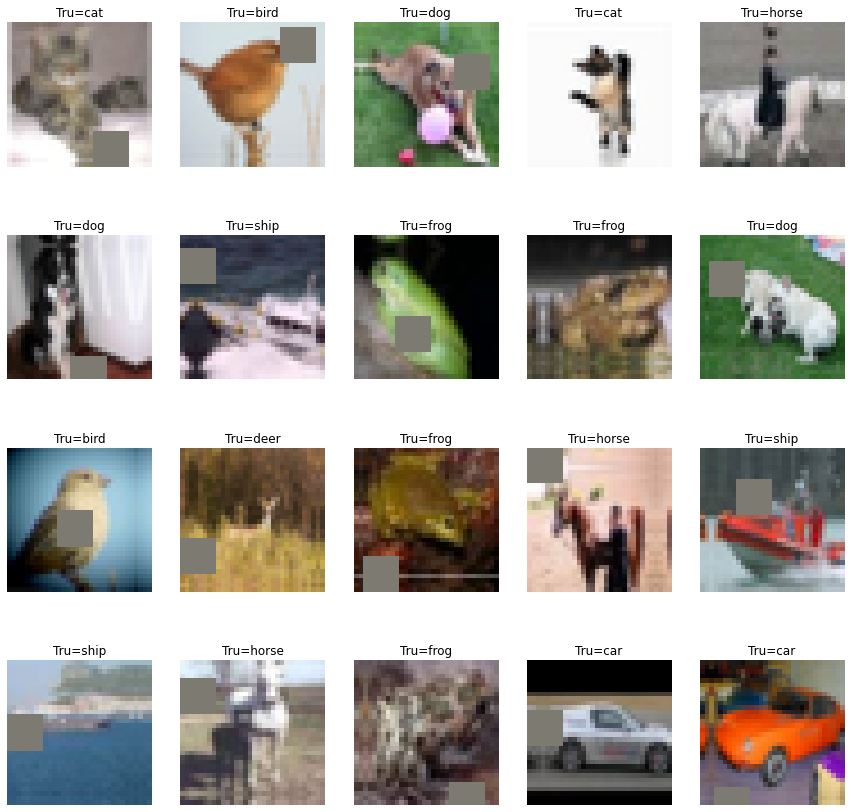

In [4]:
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)

mean_array = np.array([*mean])


train_transforms = Compose([
                            PadIfNeeded(40, 40, always_apply=True, p=1.0),
                            RandomCrop(32, 32, always_apply=True, p=1.0),
                            HorizontalFlip(p=0.5),
                            Cutout(num_holes=1, max_h_size=8, max_w_size=8, fill_value=np.array([*mean])*255.0, p=0.75),
                            Normalize(mean, std),
                            ToTensor()
])
  
test_transforms = Compose([
          Normalize(mean, std),
          ToTensor()
          ])

data=DataUtility.download_CIFAR10(Alb(train_transforms), Alb(test_transforms), batch_size=512)
DataUtility.showLoaderImages(data.train, count=20, classes=data.classes, muSigmaPair=(mean, std))

## Initialize the network and view the summary

In [5]:
from torchsummary import summary
summary(S11Resnet().to(Utility.getDevice()), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
        InputLayer-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,728
         MaxPool2d-6          [-1, 128, 16, 16]               0
       BatchNorm2d-7          [-1, 128, 16, 16]             256
              ReLU-8          [-1, 128, 16, 16]               0
  ConvMaxPoolBlock-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
             ReLU-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 128, 16, 16]         147,456
      BatchNorm2d-14          [-1, 128,

/content/drive/My Drive/Colab Notebooks/workspace/eva/cnn-lib/src/cnnlib/models/S11Resnet.py:95: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


## LR Finder

/content/drive/My Drive/Colab Notebooks/workspace/eva/cnn-lib/src/cnnlib/models/S11Resnet.py:95: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Learning rate search finished. See the graph with {finder_name}.plot()


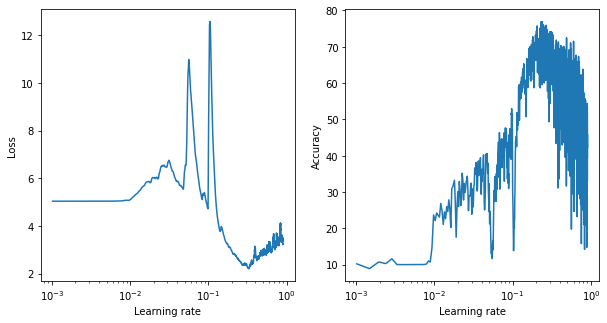

In [7]:
net = S11Resnet().to(Utility.getDevice())
criterion = LossFn(F.nll_loss, model=net, l2Factor=0.05)
optimizer = optim.SGD(net.parameters(), lr = 1e-5, momentum=0.9)
finder = LRFinder(net, optimizer, criterion, device="cuda")

finder.range_test(data.train, val_loader=data.test, start_lr=0.0001, end_lr=0.9,
                     num_iter=20 * len(data.train), step_mode="linear")
finder.plot()
finder.reset()


In [8]:
bestLR = finder.history["lr"][finder.history["loss"].index(finder.best_loss)]
print(f"Best LR: {bestLR}")
finder.reset()

Best LR: 0.3224111224489796


## Train the network

In [9]:
epochs = 24
net = S11Resnet().to(Utility.getDevice())
optimizer = optim.SGD(net.parameters(), lr = bestLR, momentum=0.9)
scheduler = OneCycleLR(optimizer, max_lr=bestLR, epochs=epochs, steps_per_epoch=len(data.train), 
                       pct_start=5/epochs, anneal_strategy='linear', div_factor=25.0, final_div_factor=1)
builder = ModelBuilder(net, data, criterion, optimizer, scheduler)
result = builder.fit(epochs)



Epoch: 1


/content/drive/My Drive/Colab Notebooks/workspace/eva/cnn-lib/src/cnnlib/models/S11Resnet.py:95: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Train Accuracy: 16.558%, Train Loss: 0.013754790648818016, Learning Rate: 0.012896444897959184



Test Accuracy: 22.89%, Test Loss: 0.011139429174363613


Epoch: 2



Train Accuracy: 28.138%, Train Loss: 0.009774565696716309, Learning Rate: 0.07492597127832729



Test Accuracy: 36.96%, Test Loss: 0.009012075141072273


Epoch: 3



Train Accuracy: 41.114%, Train Loss: 0.008578379638493061, Learning Rate: 0.13695549765869539



Test Accuracy: 48.53%, Test Loss: 0.008334419690072536


Epoch: 4



Train Accuracy: 50.666%, Train Loss: 0.00809355080127716, Learning Rate: 0.1989850240390635



Test Accuracy: 55.27%, Test Loss: 0.007936296984553337


Epoch: 5



Train Accuracy: 58.324%, Train Loss: 0.007660465314984322, Learning Rate: 0.2610145504194316



Test Accuracy: 60.38%, Test Loss: 0.007668521720916033


Epoch: 6



Train Accuracy: 65.218%, Train Loss: 0.007315354887396097, Learning Rate: 0.3222448954470725



Test Accuracy: 69.12%, Test Loss: 0.00721685541793704


Epoch: 7



Train Accuracy: 70.512%, Train Loss: 0.007018010597676039, Learning Rate: 0.30595464926017674



Test Accuracy: 73.86%, Test Loss: 0.006976281758397818


Epoch: 8



Train Accuracy: 74.41%, Train Loss: 0.006801166106015444, Learning Rate: 0.2896644030732809



Test Accuracy: 73.34%, Test Loss: 0.0070888930931687355


Epoch: 9



Train Accuracy: 77.136%, Train Loss: 0.006652229931205511, Learning Rate: 0.2733741568863851



Test Accuracy: 78.11%, Test Loss: 0.0067500523291528225


Epoch: 10



Train Accuracy: 79.624%, Train Loss: 0.006512437015771866, Learning Rate: 0.25708391069948927



Test Accuracy: 80.07%, Test Loss: 0.006635804660618305


Epoch: 11



Train Accuracy: 81.656%, Train Loss: 0.006399854552000761, Learning Rate: 0.24079366451259343



Test Accuracy: 79.91%, Test Loss: 0.006646822206676006


Epoch: 12



Train Accuracy: 82.62%, Train Loss: 0.006342758424580097, Learning Rate: 0.22450341832569765



Test Accuracy: 82.73%, Test Loss: 0.006479065399616957


Epoch: 13



Train Accuracy: 84.06%, Train Loss: 0.006262169219553471, Learning Rate: 0.2082131721388018



Test Accuracy: 82.9%, Test Loss: 0.006495421286672354


Epoch: 14



Train Accuracy: 84.9%, Train Loss: 0.006194442510604858, Learning Rate: 0.19192292595190602



Test Accuracy: 82.53%, Test Loss: 0.006530213635414839


Epoch: 15



Train Accuracy: 86.11%, Train Loss: 0.00614140322431922, Learning Rate: 0.1756326797650102



Test Accuracy: 82.45%, Test Loss: 0.006523393094539642


Epoch: 16



Train Accuracy: 86.66%, Train Loss: 0.00610244320705533, Learning Rate: 0.1593424335781144



Test Accuracy: 85.81%, Test Loss: 0.006325325462967157


Epoch: 17



Train Accuracy: 87.906%, Train Loss: 0.006037810351699591, Learning Rate: 0.14305218739121858



Test Accuracy: 85.37%, Test Loss: 0.006368862930685282


Epoch: 18



Train Accuracy: 88.57%, Train Loss: 0.00599256157875061, Learning Rate: 0.12676194120432277



Test Accuracy: 85.88%, Test Loss: 0.006309601943939924


Epoch: 19



Train Accuracy: 89.606%, Train Loss: 0.005938887130469084, Learning Rate: 0.11047169501742693



Test Accuracy: 87.0%, Test Loss: 0.00628115888684988


Epoch: 20



Train Accuracy: 90.364%, Train Loss: 0.005887178238481283, Learning Rate: 0.09418144883053112



Test Accuracy: 87.22%, Test Loss: 0.006266377400606871


Epoch: 21



Train Accuracy: 91.36%, Train Loss: 0.005842868704348803, Learning Rate: 0.0778912026436353



Test Accuracy: 87.71%, Test Loss: 0.006221514195203781


Epoch: 22



Train Accuracy: 91.782%, Train Loss: 0.005810702219605446, Learning Rate: 0.06160095645673952



Test Accuracy: 87.83%, Test Loss: 0.006241621449589729


Epoch: 23



Train Accuracy: 92.776%, Train Loss: 0.0057555027306079865, Learning Rate: 0.04531071026984368



Test Accuracy: 88.7%, Test Loss: 0.006212761625647545


Epoch: 24



Train Accuracy: 93.762%, Train Loss: 0.005701133981347084, Learning Rate: 0.029020464082947894



Test Accuracy: 89.3%, Test Loss: 0.0061978427693247795


## Plot metrics and loss

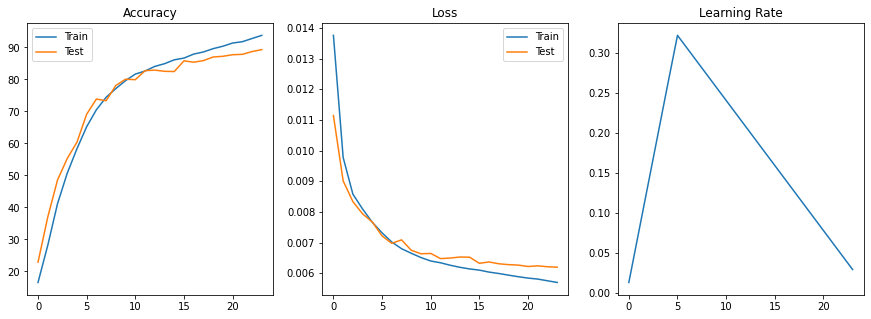

In [10]:
MetricsUtility.plotMetrics(result)

## View miss classified images

/content/drive/My Drive/Colab Notebooks/workspace/eva/cnn-lib/src/cnnlib/models/S11Resnet.py:95: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



[[931   5  10   8  11   0   2   3  24   6]
 [  5 956   0   1   0   0   1   1   7  29]
 [ 36   1 837  39  25  14  29  10   5   4]
 [ 12   1  27 824  25  66  23  11   7   4]
 [  8   1  27  39 884  11  13  16   1   0]
 [  7   2  13 126  24 806   9  10   0   3]
 [  7   2  22  41   6   6 912   0   2   2]
 [  8   2   7  28  18  16   2 918   0   1]
 [ 26   6   2   7   1   0   2   0 939  17]
 [ 13  39   2   7   0   0   3   2  11 923]]


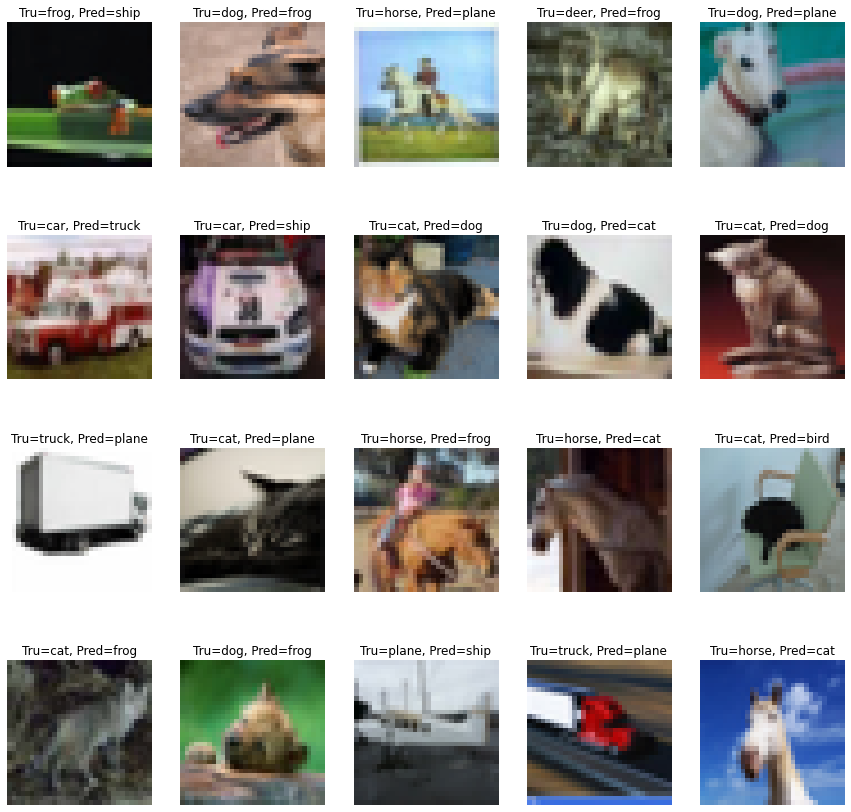

In [11]:
cpu = torch.device("cpu")
testResult = ModelTester().test(net, data.test, criterion)
metrics = MetricsUtility.computeMetrics(testResult.data, testResult.predictions, testResult.targets)
DataUtility.showRandomImages(metrics.miss_classified_data.to(cpu), metrics.miss_classified_targets.to(cpu), metrics.miss_classified_predictions.to(cpu), data.classes, muSigmaPair=(mean, std))

## Visualize GradCam

In [0]:
from GradCam import GradCam, Analyzer

cpuNet = net.to(cpu)
layers = ["layer3_resnet_block", "layer2", "layer1_resnet_block"]
analyzer = Analyzer(GradCam(cpuNet, layers))

analyzer.visualize(metrics.miss_classified_data.to(cpu), metrics.miss_classified_targets.to(cpu), data.classes, muSigPair=(mean, std), figSize=(15, 75), count=25)

/content/drive/My Drive/Colab Notebooks/workspace/eva/cnn-lib/src/cnnlib/models/S11Resnet.py:95: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
